In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# Problem 1

## 1) Download the data

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

## 2) Find and describe how the background changes

In [3]:
df = pd.DataFrame(data).transpose()
df.columns = ["gps_time", "solar_phase", "longitude", "count"]

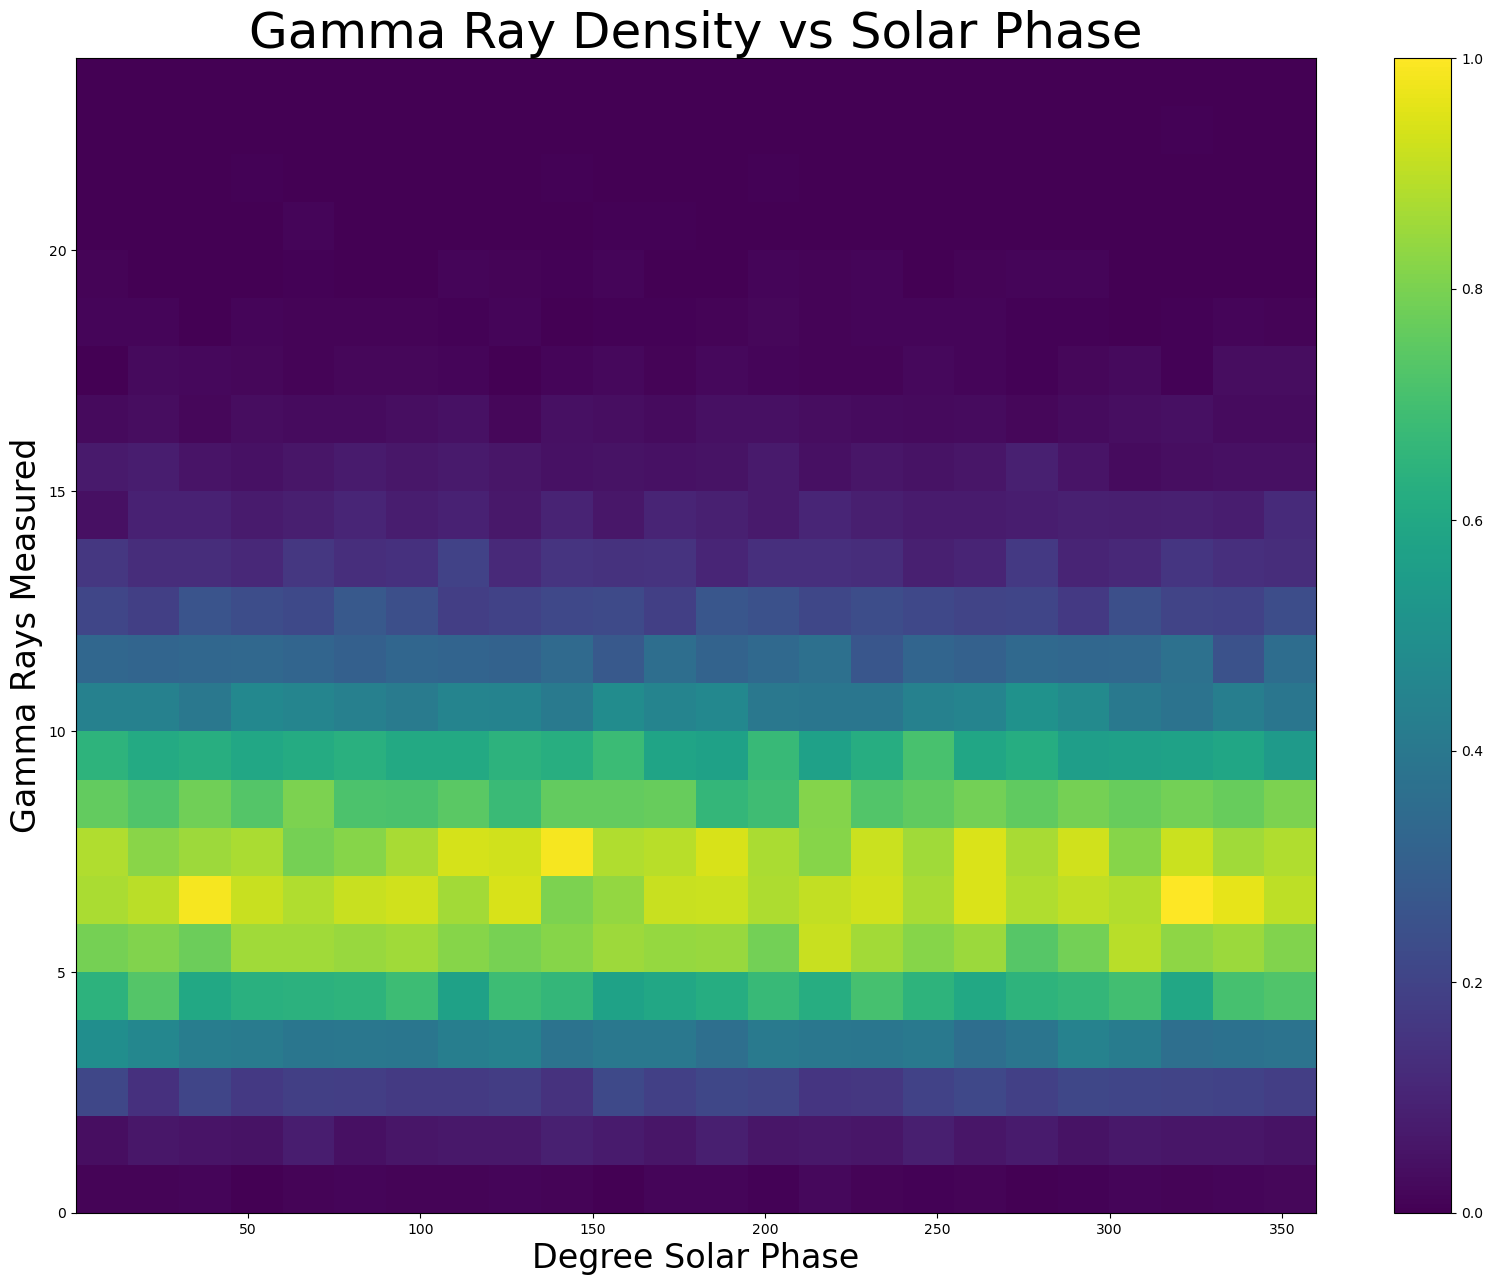

In [21]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.hist2d(df['solar_phase'][::500], df['count'][::500], bins = 24)
plt.xlabel("Degree Solar Phase", fontsize = 24)
plt.ylabel("Gamma Rays Measured", fontsize = 24)
plt.title("Gamma Ray Density vs Solar Phase", fontsize = 36)
plt.show()

We can see in the graph above the density of gamma ray measurement that there is very little to no dependance on the solar phase. At all points of solar phase, the density is relatively stable.

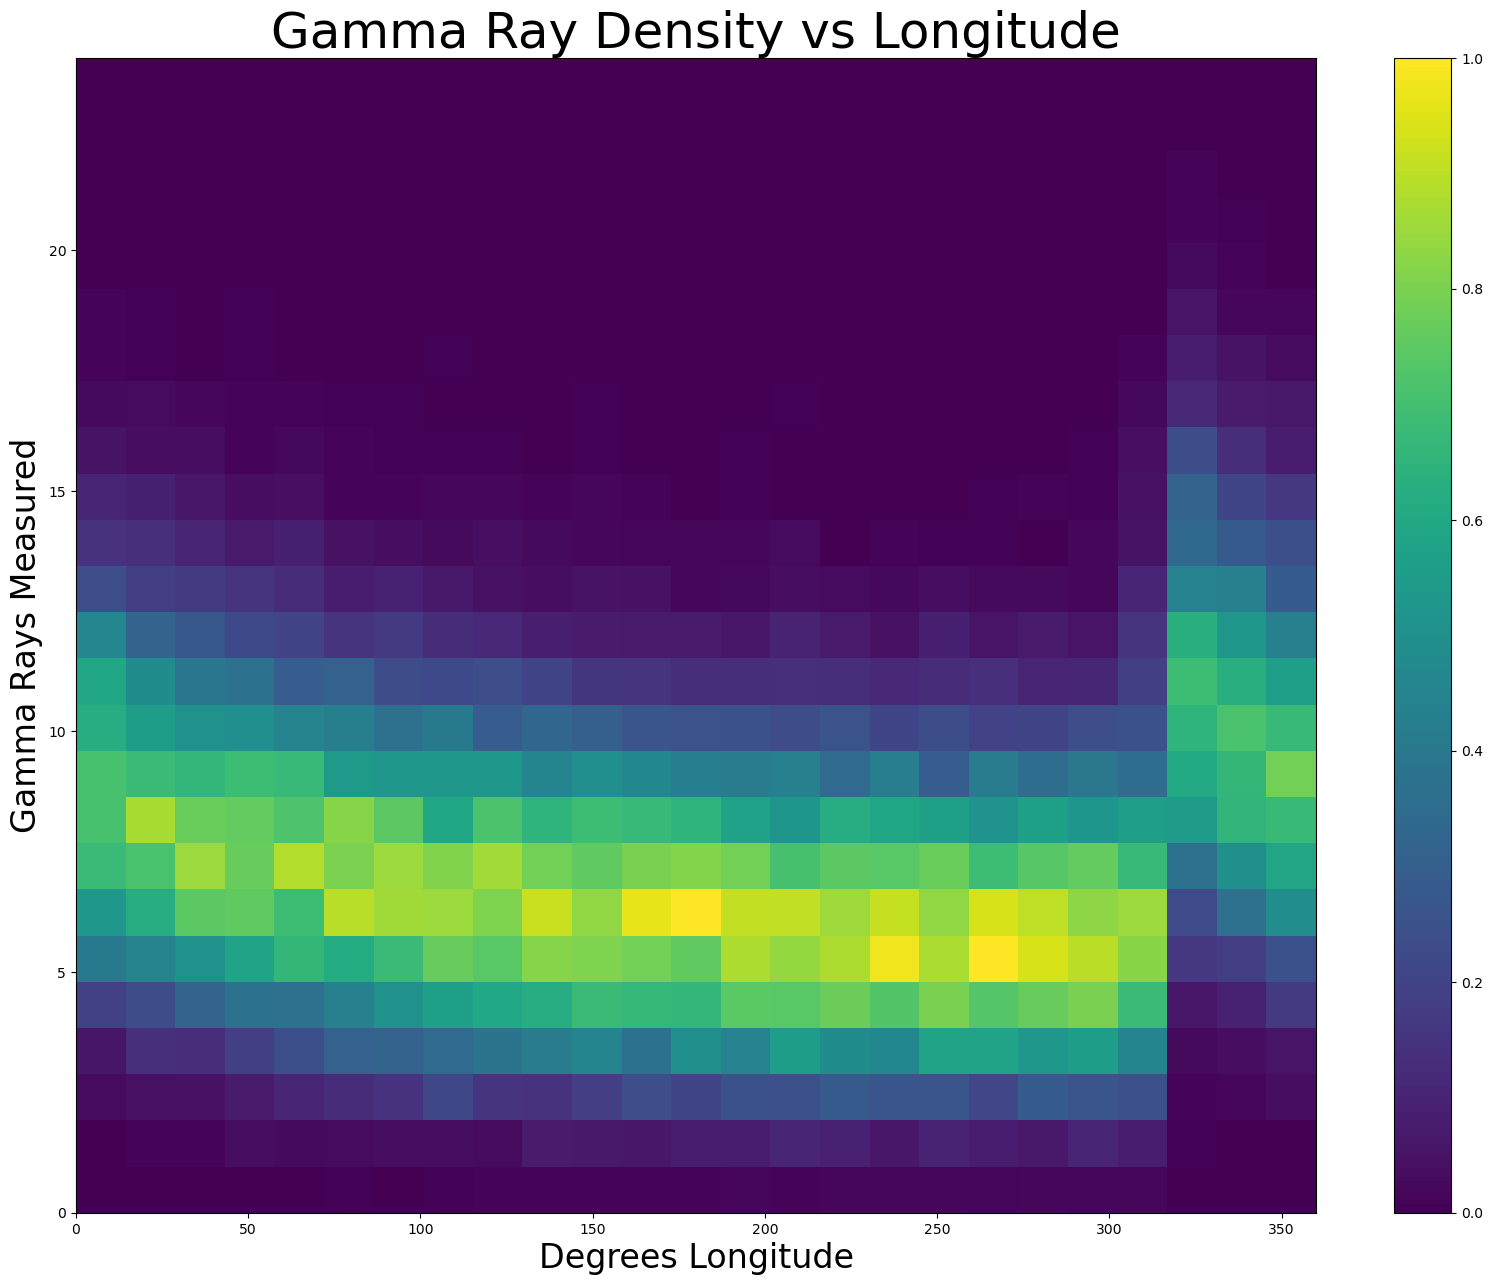

In [25]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.xlabel("Degrees Longitude", fontsize = 24)
plt.ylabel("Gamma Rays Measured", fontsize = 24)
plt.title("Gamma Ray Density vs Longitude", fontsize = 36)
plt.hist2d(df['longitude'][::502], df['count'][::502], bins = 25)
plt.show()

In [163]:
counts = [0]*360
for i in range(len(df["count"][::15])):
    counts[math.floor(df["longitude"][i*15])] += int(df["count"][i*15])
for i in range(len(counts)):
    counts[i] /= len(df["count"])/360

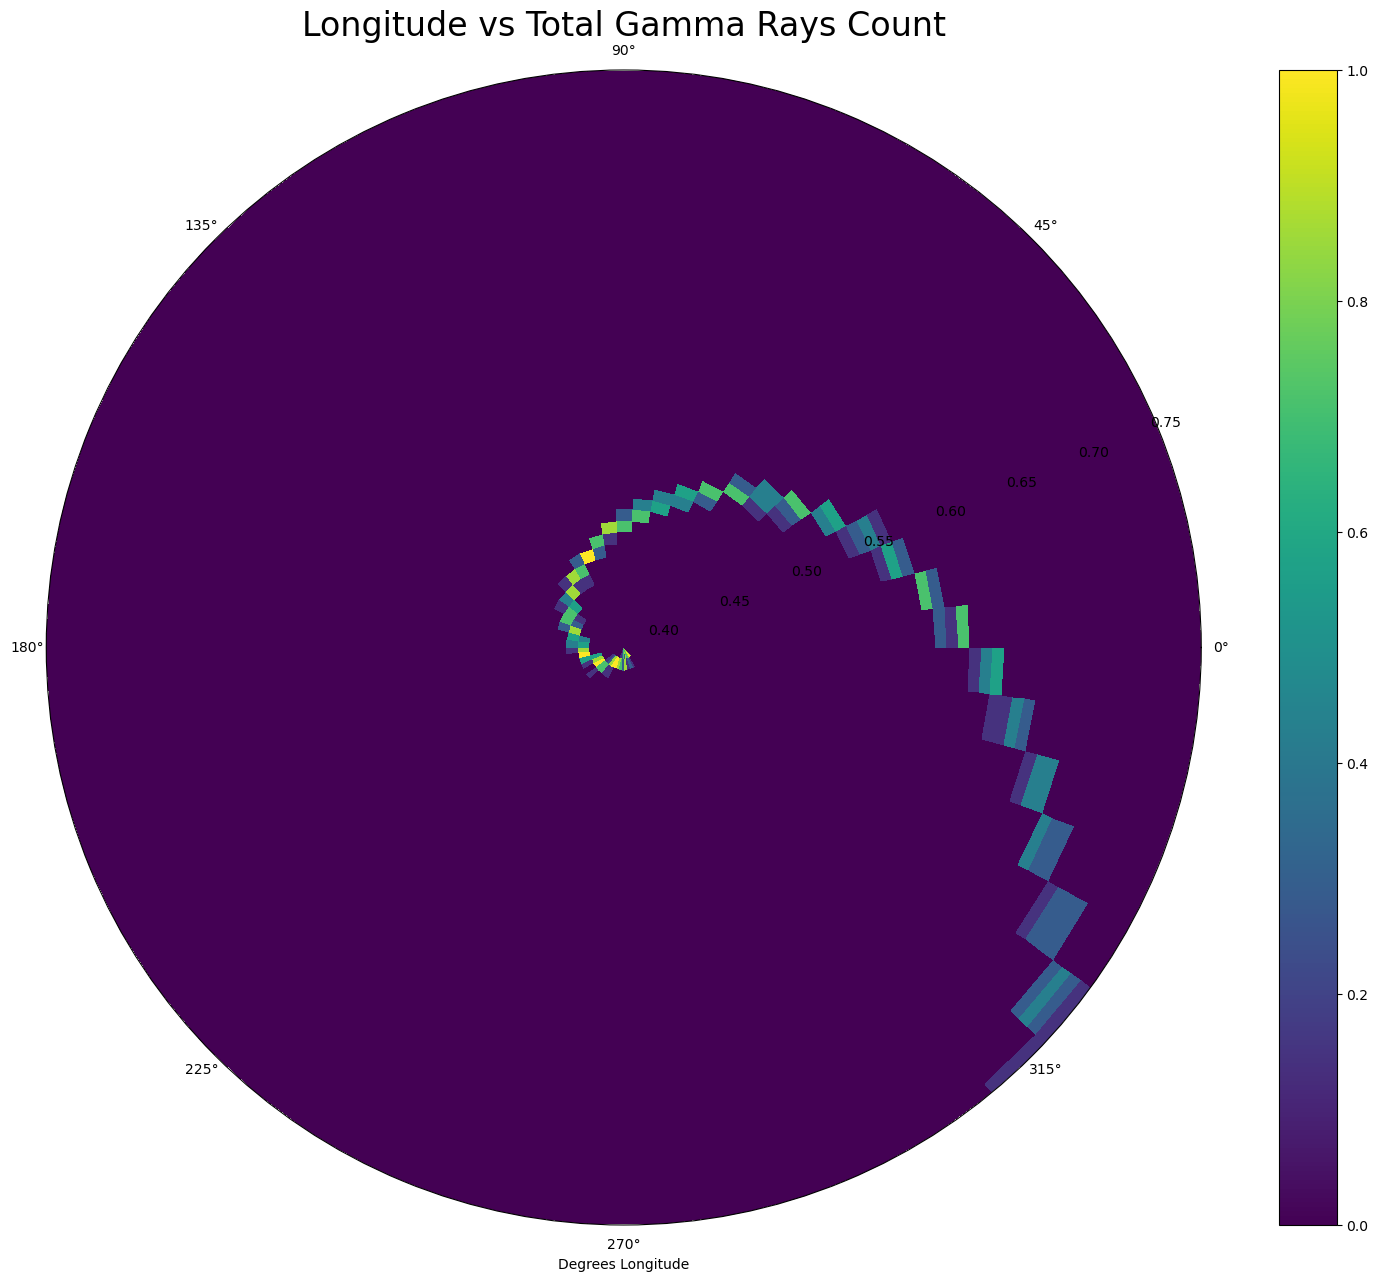

In [164]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.title("Longitude vs Total Gamma Rays Count", fontsize = 24)
plt.hist2d(np.linspace(0,2*np.pi,360), counts, bins = 50)
plt.xlabel("Degrees Longitude")
plt.show()

In the above two graphs we can see that the longitude has a significant impact on the distribution of the number of gama rays that we see. In the first graph, we see the mean of the distribution slowly decreases from 0 to 270, then sharply rises at 270, and continue to decrease till 360. The second graph shows the distribution as a polar 2D histogram, where a greater distance from the center is a higher measurement, and degree longitude corosponds directly with the degree around the circle. We begin to see a very interesting pattern appear here. We can actually see the mean grow in a spiral, showing the distribution grow as we go around the circle, then suddenly and sharply snap back to the start at a longitude of 270. From these two graphs, we can see that there is a clear relation between longitude and gamma rays that we count

# 3) Create a model for the background

In [166]:
means = [0]*54000
for i in range(54000):
    means[i] = df["count"][i::54000].mean()


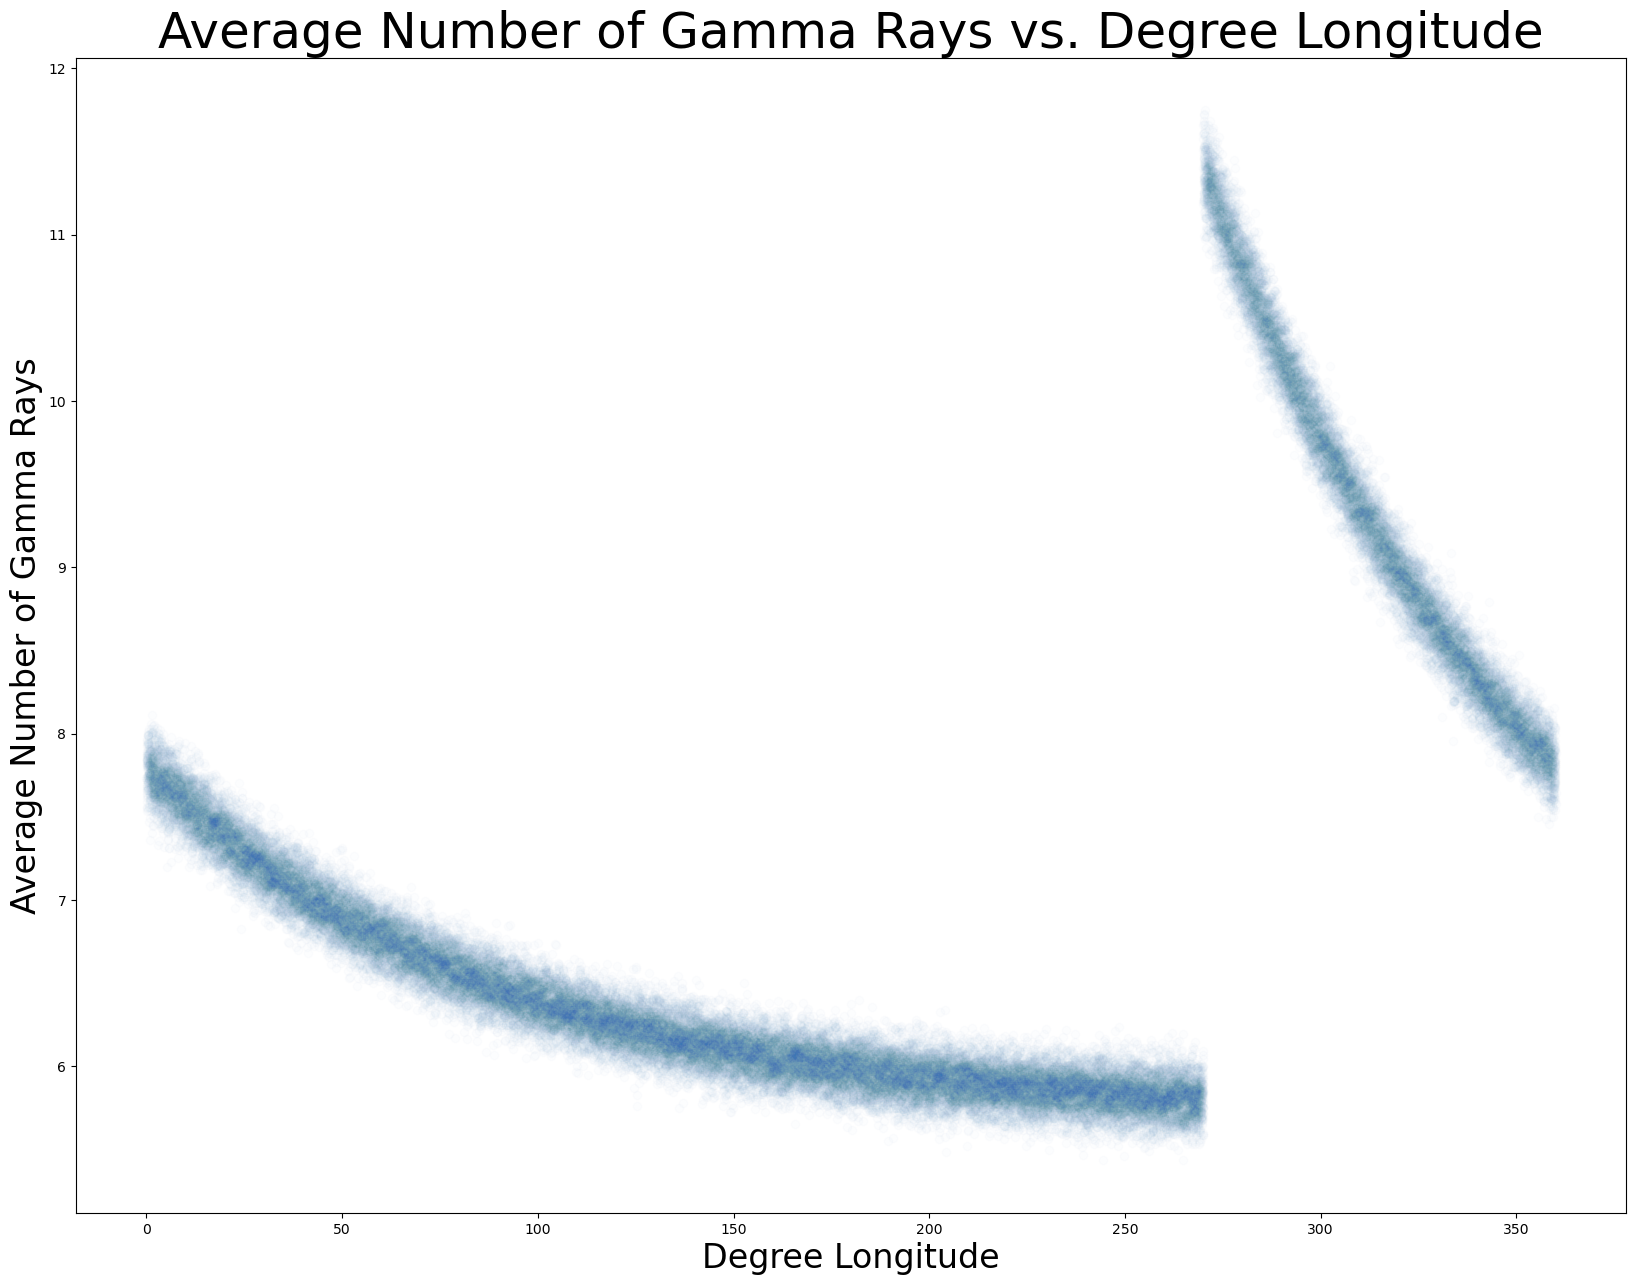

In [201]:
plt.scatter(x = np.linspace(0,360,54000),y = means, alpha = 0.01)
plt.xlabel("Degree Longitude", fontsize = 24)
plt.ylabel("Average Number of Gamma Rays", fontsize = 24)
plt.title("Average Number of Gamma Rays vs. Degree Longitude", fontsize = 36)
plt.show()

In [168]:
rearanged_means = means[40500:] + means[:40500]

In [ ]:
x = np.linspace(0,54000,54000)
y = scipy.stats.expon.pdf(x, scale = 13750)*78000+5.7
plt.scatter(x=x,y = rearanged_means, alpha = 0.01)
plt.plot(x, y, color = "red")
plt.xlabel("Time (s)", fontsize = 24)
plt.ylabel("Average Number of Gamma Rays", fontsize = 24)
plt.title("Average Number of Gamma Rays vs. Time", fontsize = 36)
plt.show()

The above two graphs show the mean as a function of time. The first graph is starting at the start of the data set, and plotting the mean of every logitudinal point where data was taken, which are all isochronous. The second shows the same data, except shifted by 40500 measurements, and overlayed with an exponential curve. We can see that with some scaling adjustments to the curve, we find a nicely fitting overlay on the data. The equation for such a curve would be $f(t) = \frac{312}{55}e^{\frac{-t}{13750}}+5.57$, where $f(t)$ is number of expected gamma rays, and $t$ is time.

4639.0

0     45.000000
1     45.006667
2     45.013333
3     45.020000
4     45.026667
5     45.033333
6     45.040000
7     45.046667
8     45.053333
9     45.060000
10    45.066667
11    45.073333
12    45.080000
13    45.086667
14    45.093333
15    45.100000
16    45.106667
17    45.113333
18    45.120000
19    45.126667
Name: longitude, dtype: float64